In [1]:
import numpy as np

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import seml.database as db_utils
from pathlib import Path

import torch

from itertools import product

from statsmodels.stats.proportion import proportion_confint

import pandas as pd

import os

import sys
sys.path.append('../..')
from utils import load_results, plot_results_dict

In [2]:
collection = 'equivariance_attributes_ibp'

jk_config = {
    'username': 'your-username',
    'password': 'your-password',
    'host': 'your-host-address',
    'port': 27017,
    'db_name': 'your-dbname'
}

col = db_utils.get_collection(collection, mongodb_config=jk_config)

In [3]:
def get_experiments(col, restrictions={}):
    
    restrictions['status'] = 'COMPLETED'

    if col.count_documents(restrictions) == 0:
        raise ValueError('No matches!')

    exps = col.find(restrictions, {'config':1, 'result': 1, '_id': 1})
    
    return exps

In [4]:
def get_certificates(raw_results_file):
    raw_results = torch.load(raw_results_file)

    idx_test = raw_results['idx_test']
    preds = raw_results['pred'][idx_test]
    targets = raw_results['targets'][idx_test]
    certified = raw_results['certified'][:, idx_test]
    correct = (preds == targets)[np.newaxis]

    accuracy = correct.mean()
    certified_ratios = certified.mean(axis=1)
    certified_ratios = np.insert(certified_ratios, 0, 1)
    certified_accuracies = (correct & certified).mean(axis=1)
    certified_accuracies = np.insert(certified_accuracies, 0, accuracy)

    return {
        'accuracy': accuracy,
        'certified_ratios': certified_ratios,
        'certified_accuracies': certified_accuracies
    }

In [5]:
def generate_exp_result_dict(exp):

    result_dict = {}

    result_dict['seed'] = exp['config']['seed']

    result_dict['dataset'] = exp['config']['dataset_params']['name']
    result_dict['hidden_sizes'] = exp['config']['hidden_sizes']
    
    result_dict['q'] = exp['config']['certification_params']['q']
    
    result_dict['cost_add'] = exp['config']['certification_params']['cost_add']
    result_dict['cost_del'] = exp['config']['certification_params']['cost_del']

    save_dir = exp['config']['save_dir']
    db_collection = exp['config']['db_collection']
    run_id = exp['_id']
    save_file = f'{save_dir}/{db_collection}_{run_id}'

    result_dict['raw_results_file'] = save_file

    cert_dict = get_certificates(result_dict['raw_results_file'])

    result_dict.update(cert_dict)

    return result_dict

In [6]:
# Use commented out code if you want to use your own data
#experiments = get_experiments(col)
#results = load_results(
#            generate_exp_result_dict,
#            experiments,
#            results_file='./raw_data',
#            #overwrite=True
#            )
            
results = load_results(
            generate_exp_result_dict,
            None,
            results_file='./raw_data',
            overwrite=False
            )

In [7]:
results

,seed,dataset,hidden_sizes,q,cost_add,cost_del,raw_results_file,accuracy,certified_ratios,certified_accuracies
0,0,Citeseer,[32],0.0100,1,1,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.682447,"[1.0, 0.6845744680851064, 0.44468085106382976,...","[0.6824468085106383, 0.5212765957446809, 0.351..."
1,0,Cora,[32],0.0100,1,1,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.800454,"[1.0, 0.6761904761904762, 0.3904761904761905, ...","[0.800453514739229, 0.5981859410430839, 0.3691..."
2,0,Citeseer,[32],0.0100,2,1,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.681915,"[1.0, 0.6835106382978723, 0.44361702127659575,...","[0.6819148936170213, 0.5202127659574468, 0.350..."
3,0,Citeseer,[32],0.0100,3,1,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.681915,"[1.0, 0.6835106382978723, 0.44361702127659575,...","[0.6819148936170213, 0.5202127659574468, 0.350..."
4,0,Citeseer,[32],0.0100,4,1,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.681915,"[1.0, 0.6835106382978723, 0.44361702127659575,...","[0.6819148936170213, 0.5202127659574468, 0.350..."
...,...,...,...,...,...,...,...,...,...,...
345,4,Citeseer,[32],0.0025,1,3,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.681383,"[1.0, 0.7388297872340426, 0.5329787234042553, ...","[0.6813829787234043, 0.5563829787234043, 0.416..."
346,4,Citeseer,[32],0.0025,1,4,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.680851,"[1.0, 0.7420212765957447, 0.5382978723404256, ...","[0.6808510638297872, 0.5574468085106383, 0.421..."
347,4,Cora,[32],0.0025,1,2,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.807710,"[1.0, 0.6884353741496598, 0.42766439909297055,...","[0.8077097505668934, 0.6154195011337869, 0.403..."
348,4,Cora,[32],0.0025,1,3,/nfs/staff-hdd/schuchaj/equivariance_certifica...,0.807710,"[1.0, 0.6875283446712018, 0.4249433106575964, ...","[0.8077097505668934, 0.6149659863945578, 0.402..."


In [8]:
def prepare_plot_dict(res, cost_add=True):
    plot_dict = {}

    cost_key = 'cost_add' if cost_add else 'cost_del'

    print(f'Preparing {len(res)} results.')

    for i in range(len(res)):
        row = res.iloc[i]

        cost = row[cost_key]

        if str(cost) not in plot_dict:
            plot_dict[str(cost)] = {
                'cert_metrics': [row['certified_accuracies']]
            }
        
        else:
            plot_dict[str(cost)]['cert_metrics'].append(row['certified_accuracies'])

    for cost in plot_dict:
        num_budget_steps = 200
        plot_dict[cost]['budgets'] = np.arange(num_budget_steps)

        num_seeds = len(plot_dict[cost]['cert_metrics'])
        padded_metrics = np.zeros((num_seeds, num_budget_steps))

        for i, m in enumerate(plot_dict[cost]['cert_metrics']):
            padded_metrics[i, :len(m)] = m

        plot_dict[cost]['cert_metrics'] = padded_metrics.mean(axis=0)
        plot_dict[cost]['errors'] = padded_metrics.std(axis=0) * 1

    return plot_dict

Preparing 15 results.
Max error for 1 is 0.03286702386132235
Max error for 2 is 0.033065672243270956
Max error for 4 is 0.03301886308754742


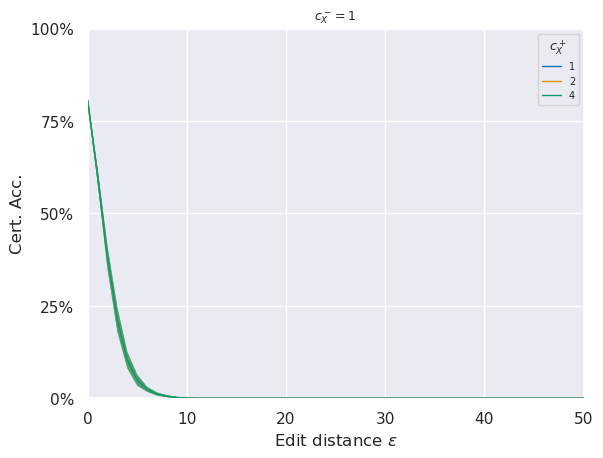

In [9]:
dataset = 'Cora'
res = results.loc[(results['dataset'] == dataset) & (results['q'] == 0.01) & (results['cost_del'] == 1) & (results['cost_add'] != 3)]
d = prepare_plot_dict(res, cost_add=True)


sns.set_theme()
plot_results_dict(d, 'Edit distance $\epsilon$', 'Cert. Acc.', legend_params={'fontsize': 7, 'title_fontsize': 9, 'title': '$c_X^+$'}, ylim=1, xlim=50, clip_on=True,
                title_params={'label': '$c_X^-=1$', 'fontsize': 9},
                yticks_params={'ticks': [0, 0.25, 0.5, 0.75, 1.0], 'labels': ['0%', '25%', '50%', '75%', '100%']}, step=False)

In [10]:
(d['1']['cert_metrics'] > 0).sum() - 1

10

Preparing 15 results.
Max error for 1 is 0.03286702386132235
Max error for 2 is 0.03317843907374983
Max error for 4 is 0.03255515682846412


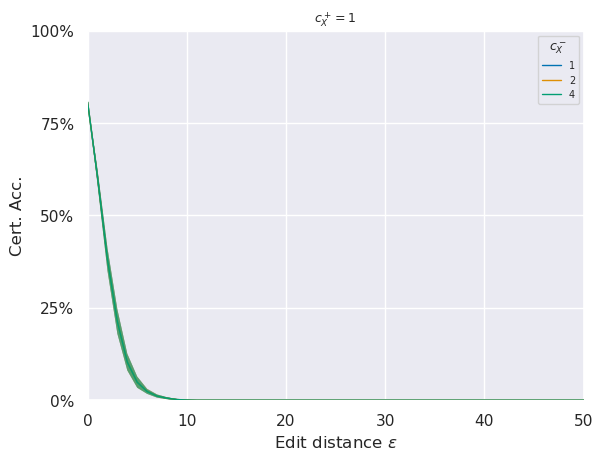

In [11]:
dataset = 'Cora'
res = results.loc[(results['dataset'] == dataset) & (results['q'] == 0.01) & (results['cost_add'] == 1) & (results['cost_del'] != 3)]
d = prepare_plot_dict(res, cost_add=False)


sns.set_theme()
plot_results_dict(d, 'Edit distance $\epsilon$', 'Cert. Acc.', legend_params={'fontsize': 7, 'title_fontsize': 9, 'title': '$c_X^-$'}, ylim=1, xlim=50, clip_on=True,
                title_params={'label': '$c_X^+=1$', 'fontsize': 9},
                yticks_params={'ticks': [0, 0.25, 0.5, 0.75, 1.0], 'labels': ['0%', '25%', '50%', '75%', '100%']}, step=False)



Preparing 15 results.
Max error for 1 is 0.05073430912338565
Max error for 2 is 0.05379508594722021
Max error for 4 is 0.05269169448091661


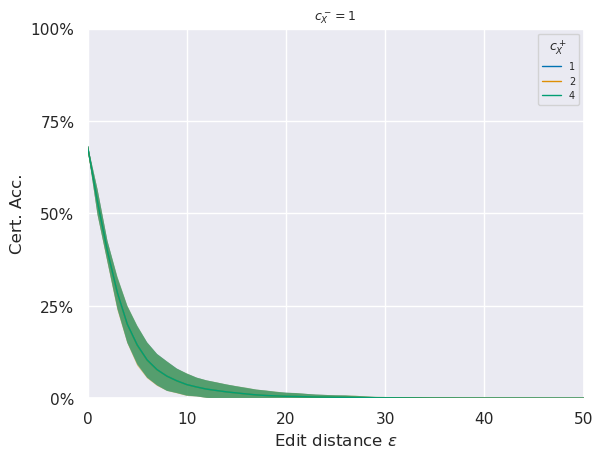

In [12]:
dataset = 'Citeseer'
res = results.loc[(results['dataset'] == dataset) & (results['q'] == 0.01) & (results['cost_del'] == 1) & (results['cost_add'] != 3)]
d = prepare_plot_dict(res, cost_add=True)


sns.set_theme()
plot_results_dict(d, 'Edit distance $\epsilon$', 'Cert. Acc.', legend_params={'fontsize': 7, 'title_fontsize': 9, 'title': '$c_X^+$'}, ylim=1, xlim=50, clip_on=True,
                title_params={'label': '$c_X^-=1$', 'fontsize': 9},
                yticks_params={'ticks': [0, 0.25, 0.5, 0.75, 1.0], 'labels': ['0%', '25%', '50%', '75%', '100%']}, step=False)


Preparing 15 results.
Max error for 1 is 0.05073430912338565
Max error for 2 is 0.0538875730540115
Max error for 4 is 0.05333173001966086


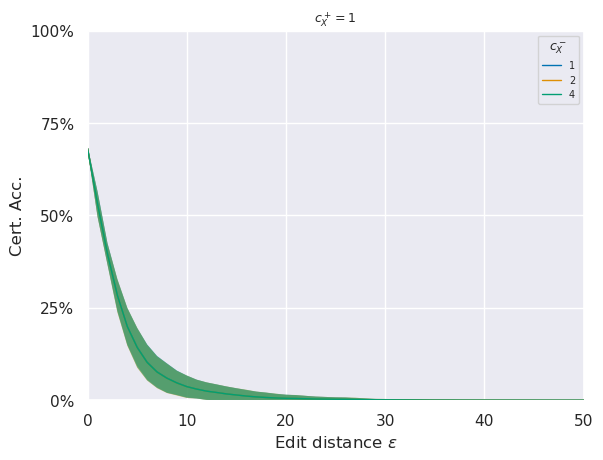

In [13]:
dataset = 'Citeseer'
res = results.loc[(results['dataset'] == dataset) & (results['q'] == 0.01) & (results['cost_add'] == 1) & (results['cost_del'] != 3)]
d = prepare_plot_dict(res, cost_add=False)


sns.set_theme()
plot_results_dict(d, 'Edit distance $\epsilon$', 'Cert. Acc.', legend_params={'fontsize': 7, 'title_fontsize': 9, 'title': '$c_X^-$'}, ylim=1, xlim=50, clip_on=True,
                title_params={'label': '$c_X^+=1$', 'fontsize': 9},
                yticks_params={'ticks': [0, 0.25, 0.5, 0.75, 1.0], 'labels': ['0%', '25%', '50%', '75%', '100%']}, step=False)

